In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import urllib
import glob
import os
import zipfile
import matplotlib.pyplot as plt
import seaborn as sns
% matplotlib inline

UsageError: Line magic function `%` not found.


In [2]:
url = 'https://raw.githubusercontent.com/lavsz/dsc-mod-2-project-v2-1-onl01-dtsc-pt-052620/master/kc_house_data.csv'

In [3]:
df = pd.read_csv(url)

In [4]:
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,0.0,...,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,...,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,0.0,0.0,...,6,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,...,7,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,...,8,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


In [5]:
df.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15'],
      dtype='object')

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
id               21597 non-null int64
date             21597 non-null object
price            21597 non-null float64
bedrooms         21597 non-null int64
bathrooms        21597 non-null float64
sqft_living      21597 non-null int64
sqft_lot         21597 non-null int64
floors           21597 non-null float64
waterfront       19221 non-null float64
view             21534 non-null float64
condition        21597 non-null int64
grade            21597 non-null int64
sqft_above       21597 non-null int64
sqft_basement    21597 non-null object
yr_built         21597 non-null int64
yr_renovated     17755 non-null float64
zipcode          21597 non-null int64
lat              21597 non-null float64
long             21597 non-null float64
sqft_living15    21597 non-null int64
sqft_lot15       21597 non-null int64
dtypes: float64(8), int64(11), object(2)
memory usage: 3.5+ MB


In [7]:
df.isnull().sum()

id                  0
date                0
price               0
bedrooms            0
bathrooms           0
sqft_living         0
sqft_lot            0
floors              0
waterfront       2376
view               63
condition           0
grade               0
sqft_above          0
sqft_basement       0
yr_built            0
yr_renovated     3842
zipcode             0
lat                 0
long                0
sqft_living15       0
sqft_lot15          0
dtype: int64

# <span style="color:##FF1493"> 1. Clean and formatting </span>
Waterfront, Basement, Renovating year Values, Date

## 1.1 Waterfront

In [8]:
df.waterfront.unique()

array([nan,  0.,  1.])

In [9]:
# Water front
# Based on King's County's map
# we assume that if any houses with nan value fall within the follow zips
# Are going to assign a 1, otherwise 0 
water_zip = [98177, 98117, 98199, 98119, 98121, 
             98101, 98104, 98134, 98126, 98116, 
             98136, 98136, 98166, 98196, 98070]
df['waterfront_adj'] = df['waterfront']
for i in range(len(df)):
    if np.isnan(df['waterfront_adj'][i]) == 1:
        if df.zipcode[i] in water_zip:
            df['waterfront_adj'][i] = 1
        elif df.zipcode[i] not in water_zip:
            df['waterfront_adj'][i] = 0
        else:
            df['waterfront_adj'][i] = df.waterfront[i]

/Applications/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Applications/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


## 1.2 Basement Square Footage

In [10]:
# Basement sqft is object is very odd
df.sqft_basement.unique()

array(['0.0', '400.0', '910.0', '1530.0', '?', '730.0', '1700.0', '300.0',
       '970.0', '760.0', '720.0', '700.0', '820.0', '780.0', '790.0',
       '330.0', '1620.0', '360.0', '588.0', '1510.0', '410.0', '990.0',
       '600.0', '560.0', '550.0', '1000.0', '1600.0', '500.0', '1040.0',
       '880.0', '1010.0', '240.0', '265.0', '290.0', '800.0', '540.0',
       '710.0', '840.0', '380.0', '770.0', '480.0', '570.0', '1490.0',
       '620.0', '1250.0', '1270.0', '120.0', '650.0', '180.0', '1130.0',
       '450.0', '1640.0', '1460.0', '1020.0', '1030.0', '750.0', '640.0',
       '1070.0', '490.0', '1310.0', '630.0', '2000.0', '390.0', '430.0',
       '850.0', '210.0', '1430.0', '1950.0', '440.0', '220.0', '1160.0',
       '860.0', '580.0', '2060.0', '1820.0', '1180.0', '200.0', '1150.0',
       '1200.0', '680.0', '530.0', '1450.0', '1170.0', '1080.0', '960.0',
       '280.0', '870.0', '1100.0', '460.0', '1400.0', '660.0', '1220.0',
       '900.0', '420.0', '1580.0', '1380.0', '475.0', 

In [11]:
# replace the '?' with -1 first
# change the dtype to float
df.sqft_basement = df.sqft_basement.str.replace('?', '-1')
df.sqft_basement = df.sqft_basement.astype(float)

## 1.3 Renovating years

In [12]:
# renovating years
df.yr_renovated.value_counts()

0.0       17011
2014.0       73
2003.0       31
2013.0       31
2007.0       30
          ...  
1946.0        1
1959.0        1
1971.0        1
1951.0        1
1954.0        1
Name: yr_renovated, Length: 70, dtype: int64

In [13]:
# replace nan with just 0 
df.yr_renovated = df.yr_renovated.fillna(0)
df.yr_renovated.unique()

array([   0., 1991., 2002., 2010., 1992., 2013., 1994., 1978., 2005.,
       2003., 1984., 1954., 2014., 2011., 1983., 1945., 1990., 1988.,
       1977., 1981., 1995., 2000., 1999., 1998., 1970., 1989., 2004.,
       1986., 2007., 1987., 2006., 1985., 2001., 1980., 1971., 1979.,
       1997., 1950., 1969., 1948., 2009., 2015., 1974., 2008., 1968.,
       2012., 1963., 1951., 1962., 1953., 1993., 1996., 1955., 1982.,
       1956., 1940., 1976., 1946., 1975., 1964., 1973., 1957., 1959.,
       1960., 1967., 1965., 1934., 1972., 1944., 1958.])

## 1.4 Sales date

In [14]:
# Sales data to datetime format
# Easy to extract month, year, weekdays for further analysis
df.date = pd.to_datetime(df.date, format='%m/%d/%Y')

# <span style="color:##FF1493"> 2. Creating a geo data frame </span>

In [15]:
geo_df = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.long, df.lat))
# geo_df.crs (setting later to match basemap)

# <span style="color:##FF1493"> 3. Finding outliers </span>

In [16]:
with pd.option_context('display.max_columns', 40):
    print(df.describe())

                 id         price      bedrooms     bathrooms   sqft_living  \
count  2.159700e+04  2.159700e+04  21597.000000  21597.000000  21597.000000   
mean   4.580474e+09  5.402966e+05      3.373200      2.115826   2080.321850   
std    2.876736e+09  3.673681e+05      0.926299      0.768984    918.106125   
min    1.000102e+06  7.800000e+04      1.000000      0.500000    370.000000   
25%    2.123049e+09  3.220000e+05      3.000000      1.750000   1430.000000   
50%    3.904930e+09  4.500000e+05      3.000000      2.250000   1910.000000   
75%    7.308900e+09  6.450000e+05      4.000000      2.500000   2550.000000   
max    9.900000e+09  7.700000e+06     33.000000      8.000000  13540.000000   

           sqft_lot        floors    waterfront          view     condition  \
count  2.159700e+04  21597.000000  19221.000000  21534.000000  21597.000000   
mean   1.509941e+04      1.494096      0.007596      0.233863      3.409825   
std    4.141264e+04      0.539683      0.086825    

In [17]:
# 33 bedrooms seems very odd and need to check out the size of the house
bed_33 = df[df.bedrooms == 33]
bed_33

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,waterfront_adj,geometry
15856,2402100895,2014-06-25,640000.0,33,1.75,1620,6000,1.0,0.0,0.0,...,580.0,1947,0.0,98103,47.6878,-122.331,1330,4700,0.0,POINT (-122.33100 47.68780)


In [18]:
# Based on the number of bathrooms, living sqft, it is definitely a typo
# The value will be corrected to 3 instead
df.bedrooms = df.bedrooms.replace({33: 3})

/Users/lavendershenghaozhang/.local/lib/python3.6/site-packages/pandas/plotting/_matplotlib/tools.py:307: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/Users/lavendershenghaozhang/.local/lib/python3.6/site-packages/pandas/plotting/_matplotlib/tools.py:307: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/Users/lavendershenghaozhang/.local/lib/python3.6/site-packages/pandas/plotting/_matplotlib/tools.py:313: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  if not layout[ax.rowNum + 1, ax.colNum]:
/U

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x105012a20>,
      dtype=object)

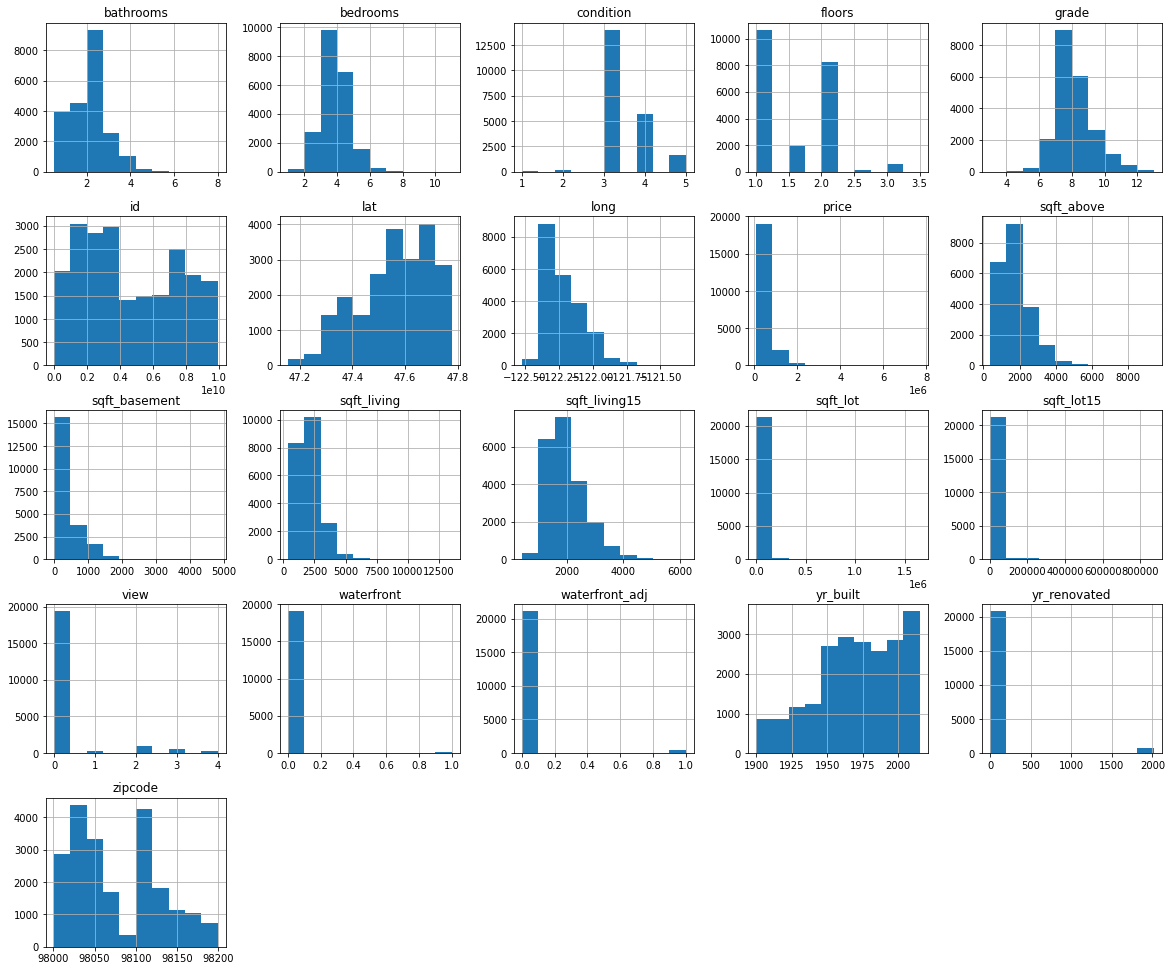

In [19]:
## Use histograms to find other outliers:
df.hist(figsize=(20,17))

# <span style="color:##FF1493"> 4. Repeating IDs </span>

In [20]:
# Are there repeating IDs?
df.id.nunique()

21420

In [21]:
# Unique ID values are less than the total entries
# There are either duplicate entries 
# Or the same house was return to the market within a short period of time
ids = df.id
duplicates = df[ids.isin(ids[ids.duplicated()])].sort_values(by=["id"])
duplicates.head(10)

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,waterfront_adj,geometry
2495,1000102,2015-04-22,300000.0,6,3.00,2400,9373,2.0,0.0,0.0,...,0.0,1991,0.0,98002,47.3262,-122.214,2060,7316,0.0,POINT (-122.21400 47.32620)
2494,1000102,2014-09-16,280000.0,6,3.00,2400,9373,2.0,NaN,0.0,...,0.0,1991,0.0,98002,47.3262,-122.214,2060,7316,0.0,POINT (-122.21400 47.32620)
16800,7200179,2014-10-16,150000.0,2,1.00,840,12750,1.0,0.0,0.0,...,0.0,1925,0.0,98055,47.4840,-122.211,1480,6969,0.0,POINT (-122.21100 47.48400)
16801,7200179,2015-04-24,175000.0,2,1.00,840,12750,1.0,0.0,0.0,...,0.0,1925,0.0,98055,47.4840,-122.211,1480,6969,0.0,POINT (-122.21100 47.48400)
11422,109200390,2014-10-20,250000.0,3,1.75,1480,3900,1.0,0.0,0.0,...,0.0,1980,0.0,98023,47.2977,-122.367,1830,6956,0.0,POINT (-122.36700 47.29770)
11421,109200390,2014-08-20,245000.0,3,1.75,1480,3900,1.0,0.0,0.0,...,0.0,1980,0.0,98023,47.2977,-122.367,1830,6956,0.0,POINT (-122.36700 47.29770)
12406,123039336,2014-12-08,244900.0,1,1.00,620,8261,1.0,0.0,0.0,...,0.0,1939,0.0,98106,47.5138,-122.364,1180,8244,0.0,POINT (-122.36400 47.51380)
12405,123039336,2014-06-11,148000.0,1,1.00,620,8261,1.0,0.0,0.0,...,0.0,1939,0.0,98106,47.5138,-122.364,1180,8244,0.0,POINT (-122.36400 47.51380)
7786,251300110,2015-01-14,358000.0,3,2.25,2510,12013,2.0,0.0,0.0,...,0.0,1988,0.0,98003,47.3473,-122.314,1870,8017,0.0,POINT (-122.31400 47.34730)
7785,251300110,2014-07-31,225000.0,3,2.25,2510,12013,2.0,0.0,0.0,...,0.0,1988,0.0,98003,47.3473,-122.314,1870,8017,0.0,POINT (-122.31400 47.34730)


In [22]:
# Find out if a house was on the market for more than twice
duplicates.id.value_counts()

795000620     3
8651402750    2
5536100020    2
7387500235    2
9238500040    2
             ..
2143700830    2
3271300955    2
1901600090    2
3323059027    2
2023049218    2
Name: id, Length: 176, dtype: int64

In [23]:
# Separate out #795000620 then look at the changes of other houses
duplicates_else = duplicates[duplicates.id !=795000620][['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_renovated', 'sqft_living15', 
                                    'sqft_lot15', 'waterfront_adj']]
id_795000620 = duplicates[duplicates.id==795000620][['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_renovated', 'sqft_living15', 
                                    'sqft_lot15', 'waterfront_adj']]
id_795000620
# We can see that it went on the market for 3 times with price getting higher
# Nothing else changed

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,view,condition,grade,sqft_above,sqft_basement,yr_renovated,sqft_living15,sqft_lot15,waterfront_adj
17588,795000620,2014-09-24,115000.0,3,1.0,1080,6250,1.0,0.0,2,5,1080,0.0,0.0,1070,6250,0.0
17589,795000620,2014-12-15,124000.0,3,1.0,1080,6250,1.0,0.0,2,5,1080,0.0,0.0,1070,6250,0.0
17590,795000620,2015-03-11,157000.0,3,1.0,1080,6250,1.0,0.0,2,5,1080,0.0,0.0,1070,6250,0.0


In [30]:
# How are other ones look like
duplicates_else = duplicates_else.sort_values(by=['id', 'date'])
duplicates_else_group = duplicates_else.groupby('id').diff().fillna(0)
duplicates_else_diff = duplicates_else_group.loc[:, (duplicates_else_group != 0).any(axis=0)]
duplicates_else_diff.waterfront_adj.value_counts(), duplicates_else_diff.sqft_basement.value_counts(), duplicates_else_diff.price.value_counts()


/Applications/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: Passing integers to fillna is deprecated, will raise a TypeError in a future version.  To retain the old behavior, pass pd.Timedelta(seconds=n) instead.
  This is separate from the ipykernel package so we can avoid doing imports until


( 0.0    347
  1.0      2
 -1.0      1
 Name: waterfront_adj, dtype: int64,  0.0      346
 -1.0        2
  701.0      1
  1.0        1
 Name: sqft_basement, dtype: int64, 0.0         178
 110000.0      4
 220000.0      3
 65000.0       3
 130000.0      3
            ... 
 125900.0      1
 110950.0      1
 165710.0      1
 107500.0      1
 211000.0      1
 Name: price, Length: 143, dtype: int64)